In [1]:
import numpy as np
import matplotlib.pyplot as plt

import utils
import model_spectra
import fitting

In [2]:
def generate_mask_from_list(**kwargs):
    wavelength = utils.load_wavelength_array()
    mask = np.array([])
    for key in kwargs:
        lower,upper = kwargs[key]
        temp_mask = np.where((wavelength > lower) & (wavelength < upper))
        mask = np.append(mask,temp_mask)
    return(mask.astype(int))

In [3]:
mask_list = {'B band':[6864,7020],
             'A band':[7591,7703],
             'strong telluric asorption':[8225,8265],
             'Ca I 6343':[6341,6346],
             'Ca I 6362':[6356,6365],
             'H alpha':[6559.797,6565.797],
             'K I 7665':[7662,7668],
             'V I 8116,8119 hyperfine structure':[8113,8123],
             'poorly modeled absorption in Arcturus':[8317,8330],
             'Ca II 8498':[8488.023,8508.023],
             'Ca II 8542':[8525.091,8561.091],
             'Ca II 8662':[8645.141,8679.141],
             'Mg I 8807':[8804.756,8809.756],
            }

In [4]:
D_PayneDir = '/Users/Nathan/Documents/Berkeley/Chemical_Evolution/DEIMOS/D-Payne/'
SpectraDir = D_PayneDir + 'spectra/synth_spectra/'
SpectraFile = 'convolved_synthetic_spectra_MIST.npz'
temp = np.load(SpectraDir + SpectraFile)
spectra = temp['spectra']
norm_spectra = temp['norm_spectra_approx']
labels = temp['labels']
temp.close()



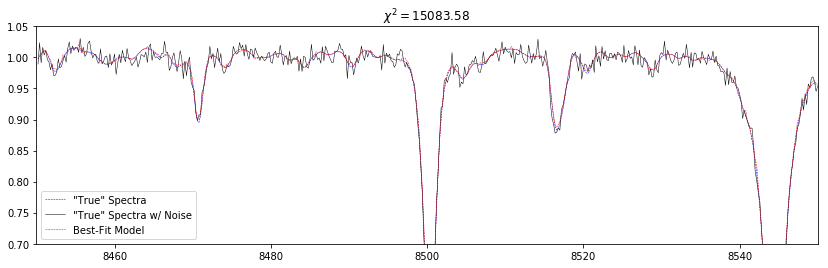

Best Fit Labels:
[  2.72162501e-03  -1.50564883e+00  -1.50248951e+00  -1.49771393e+00
  -1.50818116e+00  -1.50566963e+00  -1.50043154e+00  -1.47541302e+00
   4.09999198e+03   5.71560440e-01   5.00000000e+00   0.00000000e+00]
True Labels:
[  0.00000000e+00  -1.50000000e+00  -1.50000000e+00  -1.50000000e+00
  -1.50000000e+00  -1.50000000e+00  -1.50000000e+00  -1.50000000e+00
   4.10000000e+03   5.00000000e-01]


In [6]:
for i in range(len(spectra[:1])):
    
    wavelength = utils.load_wavelength_array()
    
    lab = labels[i]
    spec = spectra[i]
    norm_spec = norm_spectra[i]
    norm_spec_noise = norm_spectra[i] + 0.01*np.random.randn(len(norm_spectra[i]))
    #norm_spec_noise_dv = utils.doppler_shift(wavelength,norm_spec_noise,50)
    spec_err = np.ones(len(spec)) * 0.01
    
    if lab[1] < -2:
        continue
    
    # Apply Mask
    mask = generate_mask_from_list(**mask_list)
    spec_err[mask] = 999.
    #spec_err_dv = utils.doppler_shift(wavelength,spec_err,50)
    
    # Restore NN
    NN_coeffs = utils.read_in_neural_network(name='norm_spectra_approx')
    
    #Fitting
    popt, pcov, model_spec = fitting.fit_normalized_spectrum_single_star_model(norm_spec = norm_spec_noise, 
            spec_err = spec_err, NN_coeffs = NN_coeffs, 
            p0 = None, num_p0 = 5)
    chi2 = np.sum((model_spec - norm_spec_noise)**2/spec_err**2)
    
    lambda_min, lambda_max = 8450, 8550# for plotting 
    m = (wavelength < lambda_max) & (wavelength > lambda_min)
    
    plt.figure(figsize=(14, 4))
    plt.plot(wavelength[m], norm_spec[m], 'b--', lw=0.5,label = '"True" Spectra')
    plt.plot(wavelength[m], norm_spec_noise[m], 'k', lw=0.5,label = '"True" Spectra w/ Noise')
    plt.plot(wavelength[m], model_spec[m], 'r--', lw=0.5, label = 'Best-Fit Model')
    plt.xlim(lambda_min, lambda_max)
    plt.ylim(0.7, 1.05)
    plt.title(r'$\chi^2 = %.2f$' % chi2)
    plt.legend()
    plt.show()
    
    print('Best Fit Labels:')
    print(popt)
    
    print('True Labels:')
    print(lab)

In [ ]:
plt.figure(figsize=(14, 4))
plt.plot(wavelength[m], norm_spec[m], 'k', lw=0.5,label = '"True" Spectra')
plt.plot(wavelength[m], utils.doppler_shift(wavelength,norm_spec,100)[m], 'b--', lw=0.5,label = '"True" Spectra w/ Doppler Shift')
plt.xlim(lambda_min, lambda_max)
plt.ylim(0.7, 1.05)
plt.title(r'$\chi^2 = %.2f$' % chi2)
plt.legend()
plt.show()